In [66]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import japanize_matplotlib
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE
import datetime

## データ分析は前処理が基本

In [67]:
# データの読み込み
train = pd.read_csv("./competition/train.csv")
test = pd.read_csv("./competition/test.csv")
sample = pd.read_csv("./competition/submit_sample.csv",header=None)

# データ数の確認
print("Train:",train.shape, "Test:",test.shape, "Sample:",sample.shape)

Train: (337, 12) Test: (144, 11) Sample: (144, 2)


In [68]:
# 中身の確認
train.head()

,dateid,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,2014-04-01,125.0,Tue,1,メンチカツ,377.0,NaN,NaN,NaN,晴時々薄曇,0.0,13.9
1,2014-04-02,99.0,Wed,0,肉じゃが,380.0,NaN,NaN,NaN,薄曇一時晴,0.0,15.2
2,2014-04-03,100.0,Thu,1,酢豚,390.0,NaN,NaN,NaN,大雨,65.0,13.8
3,2014-04-04,90.0,Fri,1,和風ソースハンバーグ,350.0,NaN,NaN,NaN,晴時々曇一時雨、雷を伴う,40.0,15.3
4,2014-04-07,107.0,Mon,0,青梗菜牛肉炒め,387.0,NaN,NaN,NaN,晴後一時薄曇,0.0,11.4


In [69]:
### データ型を確認
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dateid         337 non-null    object 
 1   y              337 non-null    float64
 2   week           337 non-null    object 
 3   soldout        337 non-null    int64  
 4   name           337 non-null    object 
 5   kcal           304 non-null    float64
 6   remarks        49 non-null     object 
 7   event          28 non-null     object 
 8   payday         17 non-null     float64
 9   weather        337 non-null    object 
 10  precipitation  337 non-null    float64
 11  temperature    337 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 31.7+ KB


In [70]:
# 欠損値の確認
train.isnull().sum()

dateid             0
y                  0
week               0
soldout            0
name               0
kcal              33
remarks          288
event            309
payday           320
weather            0
precipitation      0
temperature        0
dtype: int64

In [71]:
# 要素の確認
print(train['remarks'].unique())
print(train['event'].unique())
print(train['payday'].unique())

[nan 'お楽しみメニュー' '料理長のこだわりメニュー' 'スペシャルメニュー' '近隣に飲食店複合ビルオープン' '料理長イチオシ！'
 '料理長イチオシ!' '今月のイチオシ!' '今月のこだわりメニュー' 'コンビニ改装' '弁当種類増↓']
[nan 'ママの会' 'キャリアアップ支援セミナー']
[nan  1.]


In [72]:
# 欠損値補完
train['remarks'] = train['remarks'].fillna('なし')
train['event'] = train['event'].fillna('なし')
train['payday'] = train['payday'].fillna(0)

In [73]:
# 販売数の基本統計量を確認
train['y'].describe()

count    337.000000
mean      65.192878
std       20.645712
min       25.000000
25%       53.000000
50%       62.000000
75%       72.000000
max      137.000000
Name: y, dtype: float64

<AxesSubplot:xlabel='dateid'>

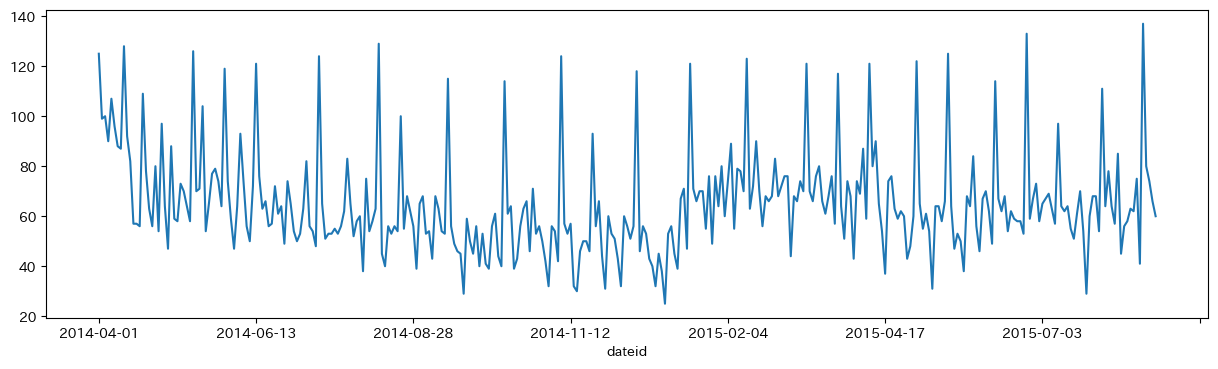

In [74]:
# 販売数推移を確認
train.index = train['dateid']
train['y'].plot(figsize=(15,4))

### 2014年は減少傾向，その後また増えたり減ったりを繰り返している
#### 時系列データの特徴が前後で少し異なる

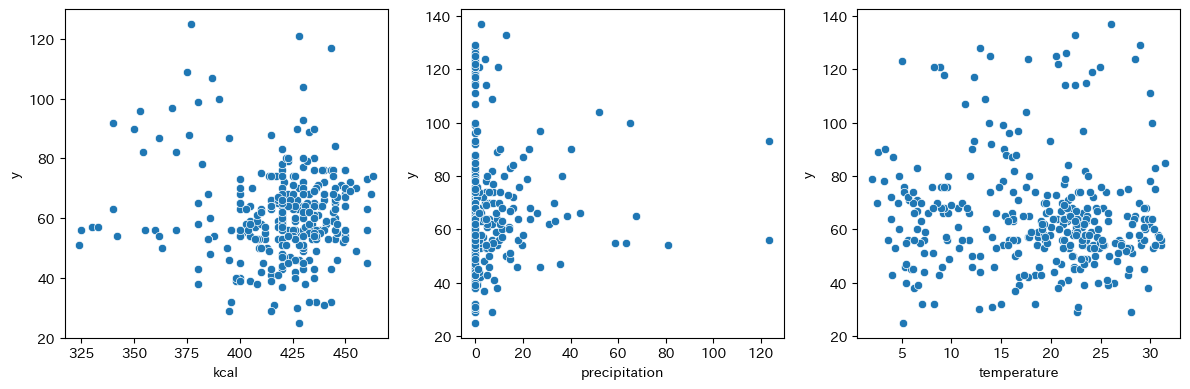

In [19]:
# 説明変数と販売数の関係性を散布図で確認
fig, ax = plt.subplots(1,3,figsize=(12,4))
sns.scatterplot(x="kcal",y="y",data=train,ax=ax[0])
sns.scatterplot(x="precipitation",y="y",data=train,ax=ax[1])
sns.scatterplot(x="temperature",y="y",data=train,ax=ax[2])
plt.tight_layout()
plt.show()

In [20]:
## 相関がないことは確認
train[['y','kcal','precipitation','temperature']].corr()

,y,kcal,precipitation,temperature
y,1.000000,-0.055984,0.079831,-0.063523
kcal,-0.055984,1.000000,0.013642,-0.209328
precipitation,0.079831,0.013642,1.000000,-0.018038
temperature,-0.063523,-0.209328,-0.018038,1.000000


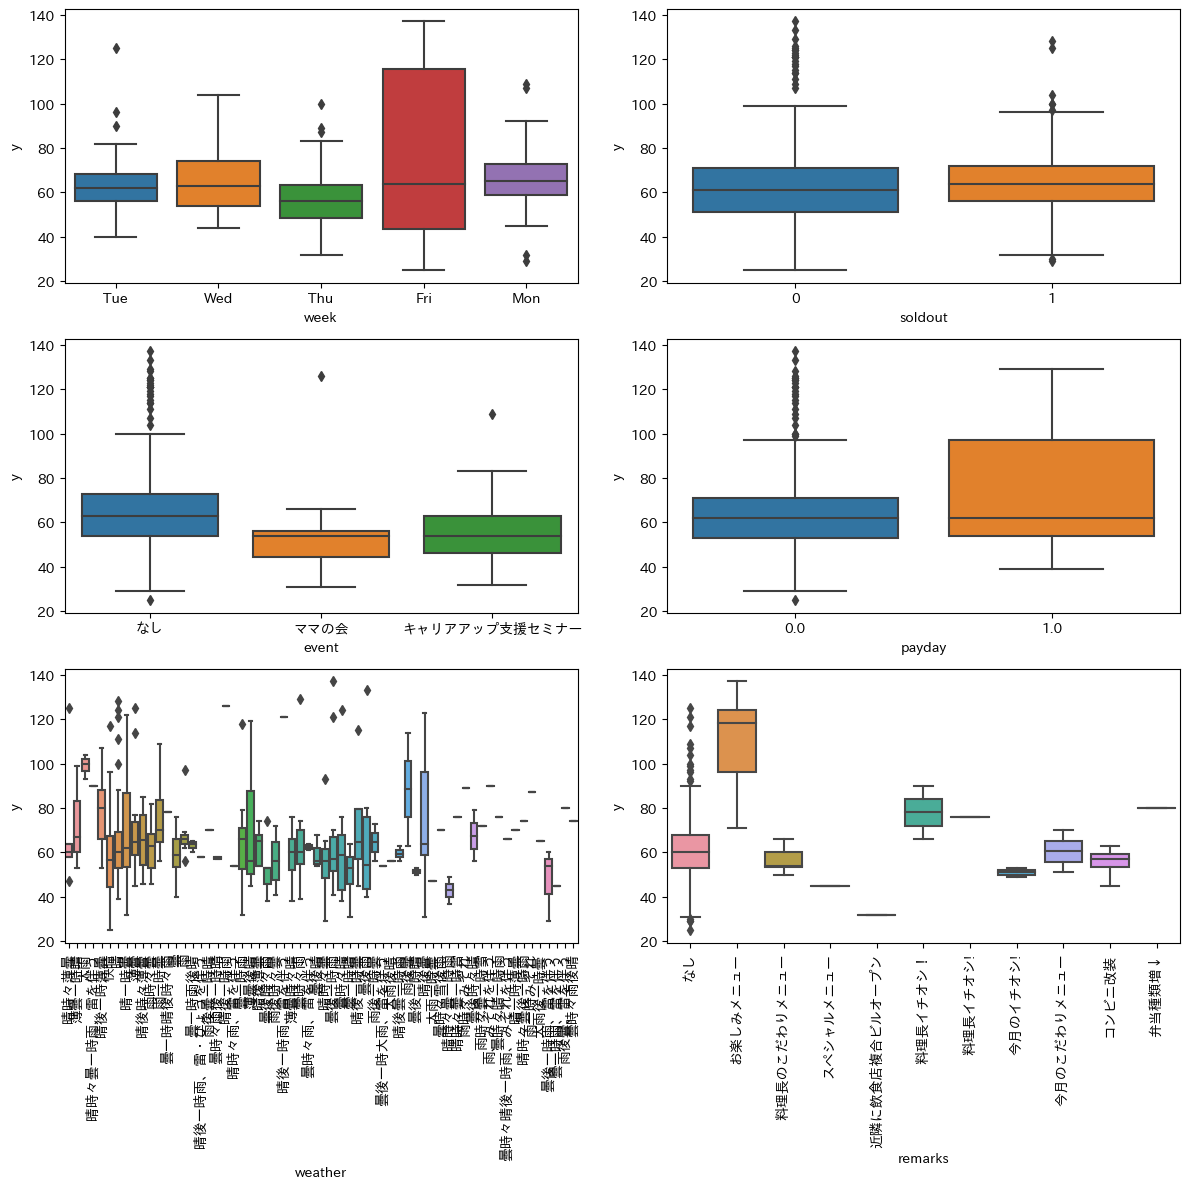

In [22]:
# 説明変数と販売数の関係性を箱ひげ図で確認
fig, ax = plt.subplots(3,2,figsize=(12,12))
sns.boxplot(x="week",y="y",data=train,ax=ax[0][0])
sns.boxplot(x="soldout",y="y",data=train,ax=ax[0][1])
sns.boxplot(x="event",y="y",data=train,ax=ax[1][0])
sns.boxplot(x="payday",y="y",data=train,ax=ax[1][1])
sns.boxplot(x="weather",y="y",data=train,ax=ax[2][0])
ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(),rotation=90)
sns.boxplot(x="remarks",y="y",data=train,ax=ax[2][1])
ax[2][1].set_xticklabels(ax[2][1].get_xticklabels(),rotation=90)
plt.tight_layout()
plt.show()

#### ・金曜の上限が大きい，波形のピークから販売数が多い日は金曜日が多い

#### ・イベントがないときの方が販売数多い

#### ・給料日の方が販売数多い

#### ・お楽しみメニューの日は販売数が多い

#### ・天気は種類が多すぎる →一部に絞ったり、集約して見た方がよさそう

In [64]:
# 1メニューあたりのデータ数が少ないので、メニュー毎の販売数の分布は見ていない
# メニュー毎の販売数の違いを見たい場合は、メニューのジャンル毎にグループ化するのが良さそう
train['name'].value_counts().head(30)

メンチカツ         9
タンドリーチキン      7
カレーライス        6
親子煮           6
豚キムチ炒め        6
ポークカレー        6
麻婆豆腐          5
豚肉のマスタード焼き    5
ポーク生姜焼き       5
鶏肉の唐揚げ        4
豚柳川           4
チーズメンチカツ      4
エビフライ         4
手作りチキンカツ      4
チンジャオロース      4
酢豚            4
チキンカレー        4
塩唐揚げ          3
白身魚カレームニエル    3
バーベキューチキン     3
手作りロースカツ      3
牛丼風煮          3
肉じゃが          3
自家製手作りトンカツ    3
鶏の味噌漬け焼き      3
キーマカレー        3
白身魚ムニエル       3
ビーフストロガノフ     3
手作りトンカツ       2
ビーフシチュー       2
Name: name, dtype: int64

In [77]:
train['weather'].value_counts().head(16)

晴        51
快晴       32
曇        23
薄曇       22
曇時々雨     13
晴時々曇     12
曇後一時雨    12
雨時々曇     12
雨一時曇     11
晴一時曇     10
曇一時雨     10
曇時々晴      9
雨         7
晴後曇       7
曇後雨       6
曇一時晴      5
Name: weather, dtype: int64

In [76]:
test['weather'].value_counts()

快晴               18
晴                13
曇                12
晴一時曇              7
曇一時晴              6
曇一時雨              5
晴後薄曇              5
曇後一時晴             4
晴一時薄曇             4
曇時々雨              4
雨後曇               3
曇後晴               3
雨時々曇              3
曇時々晴              3
曇後雨               3
薄曇一時晴             3
晴時々曇              3
晴後一時薄曇            3
雨一時曇              3
晴後曇               3
曇後一時雨             2
雨後時々曇             2
薄曇時々晴             2
晴後時々曇             2
薄曇後晴              2
大雨後一時曇            2
曇後時々雨             2
雨                 2
晴時々薄曇             2
大雨                2
晴後一時曇             2
曇時々雨一時晴           1
大雨、雷を伴う           1
薄曇                1
晴後雨時々曇            1
曇一時雨後一時晴          1
雨後一時曇             1
曇一時晴後時々雨          1
大雨後時々晴、みぞれを伴う     1
雨一時みぞれ後時々曇        1
雨後時々曇、雷を伴う        1
曇後時々晴             1
大雨後晴時々曇           1
大雨時々曇             1
薄曇後時々晴            1
Name: weather, dtype: int64

In [80]:
## 天気の要素数を減らす →　訓練用データで
train['weather_l'] = train['weather']
train.loc[~((train['weather'] == '晴')|(train['weather'] == '快晴')|(train['weather'] == '曇')|(train['weather'] == '薄曇')) , 'weather_l'] = 'その他'

[Text(0, 0, 'その他'),
 Text(1, 0, '快晴'),
 Text(2, 0, '晴'),
 Text(3, 0, '薄曇'),
 Text(4, 0, '曇')]

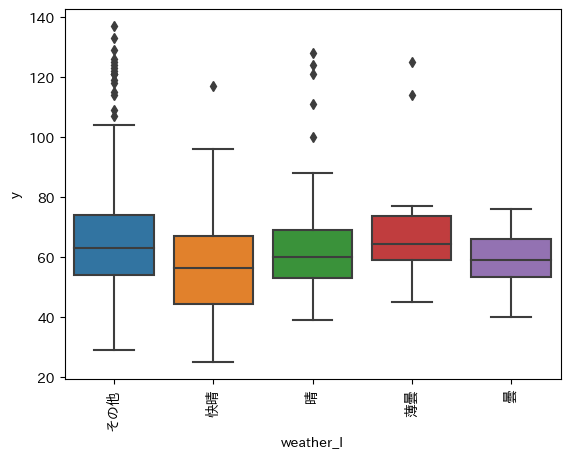

In [81]:
ax = sns.boxplot(x="weather_l",y="y",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

### チュートリアルでは、week,remarks,event,weather を特徴量として使用する

In [91]:
train = pd.read_csv("./competition/train.csv")
test = pd.read_csv("./competition/test.csv")

# データの前処理
train['train'] = 1
test['train'] = 0
data = pd.concat([train,test])
data['dateid'] = pd.to_datetime(data['dateid'])
data = data.set_index('dateid')

data['event'] = data['event'].fillna('なし')
data['payday'] = data['payday'].fillna(0)
## 天気を3種類に
data.loc[~((data['weather'] == '晴')|(data['weather'] == '快晴')|(data['weather'] == '曇')) , 'weather'] = 'その他'

select_cols = ['week', 'remarks', 'event', 'payday', 'weather', 'train', 'y']



data = pd.get_dummies(data[select_cols])

## 'train' の項目が0をtestデータとする
train = data[data['train']==1]
test = data[data['train']==0]

train = train.drop(columns=['train'])
test = test.drop(columns=['train'])

# 学習データと評価用データに分割(訓練用データのみ)
tr = train[train.index < datetime.datetime(2015,4,1)]
val = train[train.index >= datetime.datetime(2015,4,1)]

tr_X = tr.drop(columns=['y'])
tr_y = tr['y']
val_X = val.drop(columns=['y'])
val_y = val['y']

# 学習&予測
model = RandomForestRegressor(random_state=42)
model.fit(tr_X, tr_y)
tr_pred = model.predict(tr_X)
val_pred = model.predict(val_X)

# RMSEの算出
print("TRAIN:",MSE(tr_y, tr_pred)**0.5, "VARIDATE",MSE(val_y, val_pred)**0.5)

TRAIN: 15.191887539484572 VARIDATE 10.977631422507326


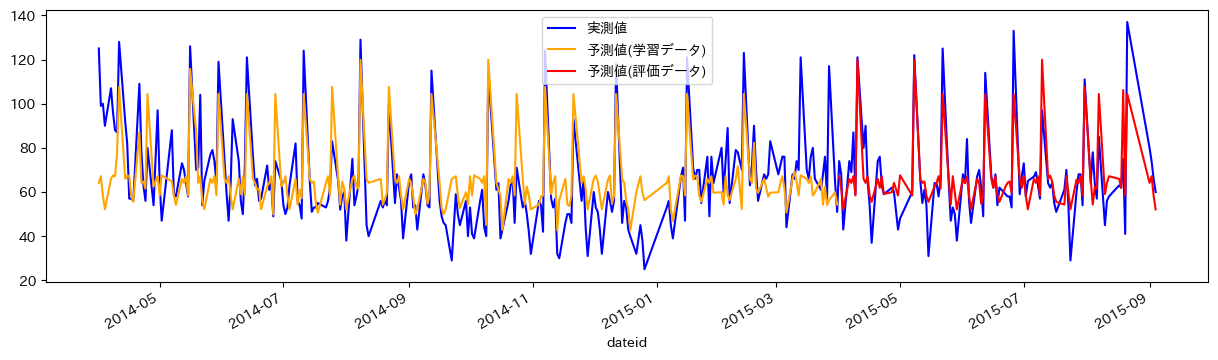

In [92]:
tr['pred'] = tr_pred
val['pred'] = val_pred

plt.figure(figsize=(15,4))
pd.concat([tr, val])['y'].plot(color='blue', label='実測値')
tr['pred'].plot(color='orange', label='予測値(学習データ)')
val['pred'].plot(color='red', label='予測値(評価データ)')
plt.legend()

#### ピークを予測できていない日がいくつか存在する

##### ピークを当てることが精度改善の一つの手がかりになるかも

In [93]:
sample = pd.read_csv("./competition/submit_sample.csv",header=None)
test_X = test.drop(columns=['y'])
test_pred = model.predict(test_X)
sample[1] = test_pred
sample.to_csv('submit26.csv', header=None, index=None)

## Gridsearch(ハイパパラメータチューニング)

In [94]:
from sklearn.model_selection import GridSearchCV

In [95]:
train = pd.read_csv("./competition/train.csv")
test = pd.read_csv("./competition/test.csv")

# データの前処理
train['train'] = 1
test['train'] = 0
data = pd.concat([train,test])
data['dateid'] = pd.to_datetime(data['dateid'])
data = data.set_index('dateid')

data['event'] = data['event'].fillna('なし')
data['payday'] = data['payday'].fillna(0)
## 天気を3種類に
data.loc[~((data['weather'] == '晴')|(data['weather'] == '快晴')|(data['weather'] == '曇')) , 'weather'] = 'その他'


select_cols = ['week', 'remarks', 'event', 'payday', 'weather', 'train', 'y']

data = pd.get_dummies(data[select_cols])

## 'train' の項目が0をtestデータとする
train = data[data['train']==1]
test = data[data['train']==0]

train = train.drop(columns=['train'])
test = test.drop(columns=['train'])

# 学習データと評価用データに分割(訓練用データのみ)
tr = train[train.index < datetime.datetime(2015,4,1)]
val = train[train.index >= datetime.datetime(2015,4,1)]

tr_X = tr.drop(columns=['y'])
tr_y = tr['y']
val_X = val.drop(columns=['y'])
val_y = val['y']

# 学習&予測
params = {"n_estimators": [10,20,30,40, 50,100, 300, 500,1000,10000], 
          "max_depth": [1,3,5,10,15, 20,None], 
          }
model2 = RandomForestRegressor(random_state=30)
model2_g = GridSearchCV(model2, params,scoring="neg_mean_squared_error")


model2_g.fit(tr_X, tr_y)
forest = model2_g.best_estimator_

tr_pred = forest.predict(tr_X)
val_pred = forest.predict(val_X)

# RMSEの算出


TRAIN: 16.774004553510544 VARIDATE 12.181546651365004


## XGBoost

In [57]:
from xgboost import XGBRegressor

In [58]:
train = pd.read_csv("./competition/train.csv")
test = pd.read_csv("./competition/test.csv")

# データの前処理
train['train'] = 1
test['train'] = 0
data = pd.concat([train,test])
data['dateid'] = pd.to_datetime(data['dateid'])
data = data.set_index('dateid')

data['event'] = data['event'].fillna('なし')
data['payday'] = data['payday'].fillna(0)

select_cols = ['week', 'remarks', 'event', 'payday', 'weather', 'train', 'y']

data = pd.get_dummies(data[select_cols])

## 'train' の項目が0をtestデータとする
train = data[data['train']==1]
test = data[data['train']==0]

train = train.drop(columns=['train'])
test = test.drop(columns=['train'])

# 学習データと評価用データに分割(訓練用データのみ)
tr = train[train.index < datetime.datetime(2015,4,1)]
val = train[train.index >= datetime.datetime(2015,4,1)]

tr_X = tr.drop(columns=['y'])
tr_y = tr['y']
val_X = val.drop(columns=['y'])
val_y = val['y']

# 学習&予測
model = XGBRegressor(early_stopping_rounds=10)
eval_set = [(val_X, val_y)]
model.fit(tr_X, tr_y, eval_set = eval_set, verbose = False)
tr_pred = model.predict(tr_X)
val_pred = model.predict(val_X)

# RMSEの算出
print("TRAIN:",MSE(tr_y, tr_pred)**0.5, "VARIDATE",MSE(val_y, val_pred)**0.5)

TRAIN: 12.741079797501074 VARIDATE 13.336036802428476


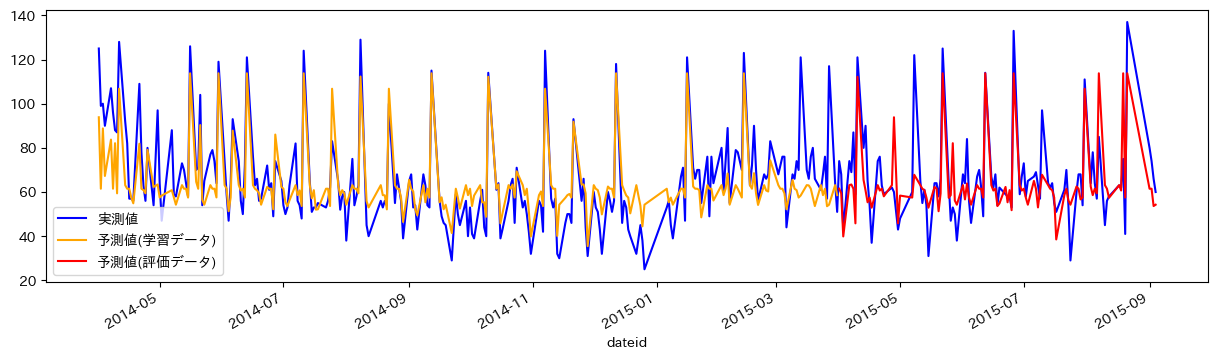

In [59]:
tr['pred'] = tr_pred
val['pred'] = val_pred

plt.figure(figsize=(15,4))
pd.concat([tr, val])['y'].plot(color='blue', label='実測値')
tr['pred'].plot(color='orange', label='予測値(学習データ)')
val['pred'].plot(color='red', label='予測値(評価データ)')
plt.legend()